#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!which python

/usr/local/bin/python


# Install dependencies:

In [ ]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [3]:
!pip install html2text

In [4]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [6]:
data_path = './data/comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [7]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./output/ 


# Load Data
Load you data as a pandas dataframe

In [8]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [9]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [10]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 946/946 [00:00<00:00, 6492.75it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [11]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-10-20 11:27:37,Thomas L.,"<a href=""https://www.youtube.com/watch?v=dtlOUMEz4y8&amp;t=1m53s"">1:53</a> Was ist wohl besser: Unsere Lebensweise zu zerstören, wie wir sie jetzt kennen, oder unsere Lebensgrundlage zu zerstören?",0,"1:53 Was ist wohl besser: Unsere Lebensweise zu zerstören, wie wir sie jetzt\nkennen, oder unsere Lebensgrundlage zu zerstören?\n\n"
1,2020-10-20 11:24:41,Thomas L.,"Die Menschheit hat in den letzten 70 Jahren mehr Energie verbraucht als in den 10.000 Jahren davor. Dass sowas nicht ohne Wirkung bleibt, kann sich auch der Dümmste ausrechnen.",0,"Die Menschheit hat in den letzten 70 Jahren mehr Energie verbraucht als in den\n10.000 Jahren davor. Dass sowas nicht ohne Wirkung bleibt, kann sich auch der\nDümmste ausrechnen.\n\n"
2,2020-09-25 16:03:15,pontius pilatus,grüne sind der untergang der wirtschaft!,0,grüne sind der untergang der wirtschaft!\n\n
3,2020-07-01 10:40:39,Seb Wilo,Klimalüge? Wie ignorant muss man eigentlich sein. Vom ignorieren verschwinden unsere Probleme sicherlich nicht...,0,Klimalüge? Wie ignorant muss man eigentlich sein. Vom ignorieren verschwinden\nunsere Probleme sicherlich nicht...\n\n
4,2020-02-22 20:03:54,Yannic,"Wie viele AfDler braucht man um eine Energiesparlampe auszuwechseln? Gar keine...sie fürchten sich vor dem ,,Made in Germany“-Aufdruck, weil es die Sprache Ausländisch ist. Ich finde den Witz auch nicht lustig. Die Wahrheit ist eben schon ziemlich mies und traurig.",0,"Wie viele AfDler braucht man um eine Energiesparlampe auszuwechseln? Gar\nkeine...sie fürchten sich vor dem ,,Made in Germany“-Aufdruck, weil es die\nSprache Ausländisch ist. Ich finde den Witz auch nicht lustig. Die Wahrheit\nist eben schon ziemlich mies und traurig.\n\n"


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [12]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [13]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 The embeddings vector is of fixed length 512


TensorShape([946, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[0.9999999  0.49750298 0.4923071  ... 0.509781   0.3585823  0.4545731 ]
 [0.49750298 0.9999999  0.44329745 ... 0.52158237 0.3000332  0.38135064]
 [0.4923071  0.44329745 1.         ... 0.5887437  0.5360403  0.54685915]
 ...
 [0.509781   0.52158237 0.5887437  ... 0.99999994 0.4265724  0.45619988]
 [0.3585823  0.3000332  0.5360403  ... 0.4265724  0.99999976 0.38809645]
 [0.4545731  0.38135064 0.54685915 ... 0.45619988 0.38809645 0.9999998 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

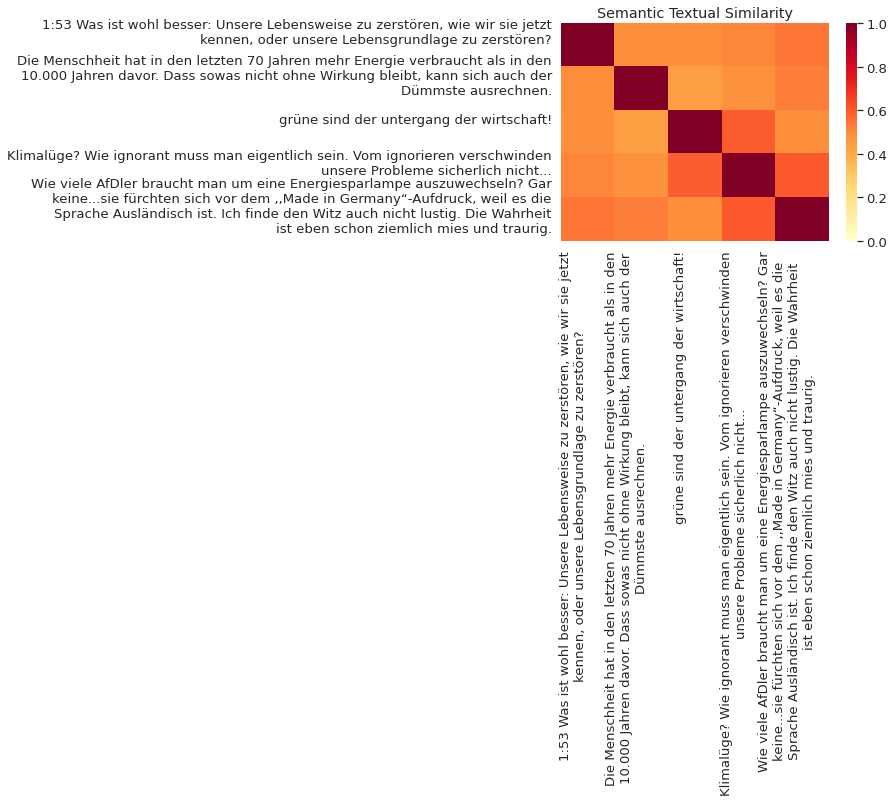

In [16]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 0 #10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [34]:
comment_index = 37 #8 #152 #9
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Dieses Thema ist bei der AFD der Grund, warum so viele bei den Wahlen dann
doch ehr die Grünen wählen. Der Klimawandel findet statt. Und zwar durch uns.
Und wer das leugnet, zeigt halt das er zu Dumm zum Regieren ist !!!




Print similar comments.

In [35]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Dieses Thema ist bei der AFD der Grund, warum so viele bei den Wahlen dann
doch ehr die Grünen wählen. Der Klimawandel findet statt. Und zwar durch uns.
Und wer das leugnet, zeigt halt das er zu Dumm zum Regieren ist !!!


Top similar comment 2: Die AfD mal wieder.. . Wissenschaft hat leider nichts mit Politik zu tun. Aber
das lernt die AfD bestimmt schon. Oder sie sind vorher schon untergegangen
weil alle Wähler der AfD glaubens, dass diese Partei Wunder vollbringen könne
und es trotzdem nicht passiert. Die AfD begeht ein riesen Fehler. Deutschland
ist nicht die Welt.


Top similar comment 3: Die wissen alle, das die AFD die Wahrheit sagt, aber in dieser Politik gibt es
nur ein weg, der weg des Geldes!


Top similar comment 4: Verbrennung ist keine Lüge und der Mensch verbrennt immer mehr.Wie man aber
damit umgeht ist für mich über die Politik ein Fehler.Denn man macht gar
nichts ,das gelingt nur radikal und mit Verboten.Alle Parteien machen nichts
auch die AfD 